#Stock Price Prediction Using Stacked LSTM

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
sns.set_theme(context='notebook', style='darkgrid', palette='pastel', font='sans-serif', font_scale=1, color_codes=True, rc=None)

## Step 1: Data Preprocessing

**Explanation:**
In this step, we prepare our data for training and testing the LSTM model. This involves the following sub-steps:

1. **Data Collection:** Obtain historical stock price data. You can use libraries like pandas or APIs to fetch this data.

2. **Data Cleaning:** Check for missing values, outliers, and inconsistencies in the data. Handle them by either removing or imputing the data.

3. **Feature Selection/Engineering:** Select relevant features for prediction or create new features that might be helpful. For stock price prediction, common features include Open Price, Close Price, High Price, Low Price, Volume, etc.

4. **Data Normalization/Scaling:** Scale the data to a common range, often between 0 and 1, to help the neural network converge faster.


###Gathering the data

In [ ]:
stock_sybol = "AAPL"
start_date = "2011-01-01"
end_date = "2023-01-01"

stocks = yf.download(stock_sybol,start_date,end_date)

[*********************100%%**********************]  1 of 1 completed


###Analyzing data


In [ ]:
stocks.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2011-01-03,11.630000,11.795000,11.601429,11.770357,9.990639,445138400
2011-01-04,11.872857,11.875000,11.719643,11.831786,10.042779,309080800
2011-01-05,11.769643,11.940714,11.767857,11.928571,10.124929,255519600
2011-01-06,11.954286,11.973214,11.889286,11.918929,10.116745,300428800
2011-01-07,11.928214,12.012500,11.853571,12.004286,10.189198,311931200


In [ ]:
stocks.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-12-23,130.919998,132.419998,129.639999,131.860001,131.299820,63814900
2022-12-27,131.380005,131.410004,128.720001,130.029999,129.477585,69007800
2022-12-28,129.669998,131.029999,125.870003,126.040001,125.504539,85438400
2022-12-29,127.989998,130.479996,127.730003,129.610001,129.059372,75703700
2022-12-30,128.410004,129.949997,127.430000,129.929993,129.378006,77034200


In [ ]:
stocks.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [ ]:
stocks.index

DatetimeIndex(['2011-01-03', '2011-01-04', '2011-01-05', '2011-01-06',
               '2011-01-07', '2011-01-10', '2011-01-11', '2011-01-12',
               '2011-01-13', '2011-01-14',
               ...
               '2022-12-16', '2022-12-19', '2022-12-20', '2022-12-21',
               '2022-12-22', '2022-12-23', '2022-12-27', '2022-12-28',
               '2022-12-29', '2022-12-30'],
              dtype='datetime64[ns]', name='Date', length=3020, freq=None)

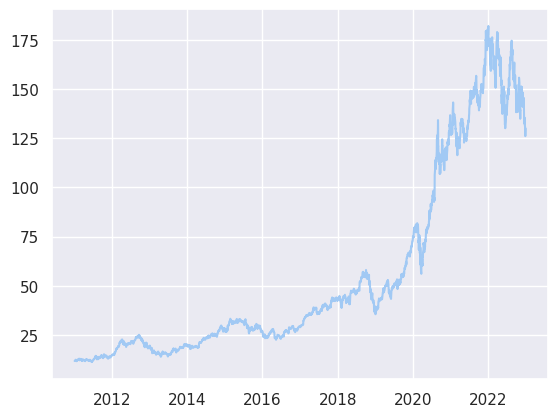

In [ ]:
plt.plot(stocks.index, stocks["Close"])

In [ ]:
stocks.shape

(3020, 6)

In [ ]:
stocks.describe()

,Open,High,Low,Close,Adj Close,Volume
count,3020.000000,3020.000000,3020.000000,3020.000000,3020.000000,3.020000e+03
mean,54.803512,55.416057,54.199822,54.829251,52.712679,2.276467e+08
std,47.614899,48.233450,47.009000,47.643466,47.979687,1.933822e+08
min,11.310000,11.346429,11.089286,11.261429,9.558663,3.519590e+07
25%,21.481785,21.681697,21.266518,21.557946,18.434194,9.841985e+07
50%,32.343750,32.642502,32.081251,32.357500,29.281694,1.524790e+08
75%,66.671251,67.504375,65.911253,66.741253,65.107136,2.934912e+08
max,182.630005,182.940002,179.119995,182.009995,180.190964,1.880998e+09


###Function to create scaled sequences from time series data

In [ ]:
def create_scaled_sequences(data, sequence_length):
    # Scale the data to a range between 0 and 1
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data.values.reshape(-1, 1))

    X, y = [], []
    for i in range(len(scaled_data) - sequence_length):
        X.append(scaled_data[i:i + sequence_length])
        y.append(scaled_data[i + sequence_length])
    return np.array(X), np.array(y), scaler

## Step 2: Data Splitting

**Explanation:**
In this step, we divide our data into training and testing sets. This is crucial to evaluate the model's performance. The training set is used to train the model, while the testing set is used to assess how well the model generalizes to unseen data.

1. **Time Series Split:** Since stock price data has a temporal aspect, we typically use a time-based split. This means we use data from earlier time periods for training and more recent data for testing.


###We consider 80% dataset as the training data and 20% as test data.

In [ ]:
len(stocks)

3020

In [ ]:
train_percentage = 0.80
split_index = int(len(stocks) * train_percentage)

train_data = stocks[0 : split_index]
test_data = stocks[split_index : len(stocks)]


In [ ]:
train_data.shape , test_data.shape

((2416, 6), (604, 6))

In [ ]:
train_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2011-01-03,11.630000,11.795000,11.601429,11.770357,9.990639,445138400
2011-01-04,11.872857,11.875000,11.719643,11.831786,10.042779,309080800
2011-01-05,11.769643,11.940714,11.767857,11.928571,10.124929,255519600
2011-01-06,11.954286,11.973214,11.889286,11.918929,10.116745,300428800
2011-01-07,11.928214,12.012500,11.853571,12.004286,10.189198,311931200
...,...,...,...,...,...,...
2020-08-03,108.199997,111.637497,107.892502,108.937500,106.810783,308151200
2020-08-04,109.132500,110.790001,108.387497,109.665001,107.524063,173071600
2020-08-05,109.377502,110.392502,108.897499,110.062500,107.913841,121776800


In [ ]:
test_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-08-10,112.599998,113.775002,110.000000,112.727501,110.726074,212403600
2020-08-11,111.970001,112.482498,109.107498,109.375000,107.433098,187902400
2020-08-12,110.497498,113.275002,110.297501,113.010002,111.003571,165598000
2020-08-13,114.430000,116.042503,113.927498,115.010002,112.968056,210082000
2020-08-14,114.830002,115.000000,113.044998,114.907501,112.867371,165565200
...,...,...,...,...,...,...
2022-12-23,130.919998,132.419998,129.639999,131.860001,131.299820,63814900
2022-12-27,131.380005,131.410004,128.720001,130.029999,129.477585,69007800
2022-12-28,129.669998,131.029999,125.870003,126.040001,125.504539,85438400


## Step 3: Sequence Generation

**Explanation:**
In this step, we create sequences of data that will be fed into the LSTM model. LSTMs are well-suited for sequence data, and for stock price prediction, we can use a sliding window approach to create input-output pairs.

1. **Define Sequence Length:** Decide on the sequence length, which represents the number of previous time steps the model will use to make predictions. For example, if you choose a sequence length of 10, the model will use the past 10 days' stock prices to predict the price for the 11th day.

2. **Create Sequences:** Create input-output pairs (X and y) by sliding the sequence window through the training data. X contains the historical prices, and y contains the target price to be predicted.


### Performing Time Series Split

In [ ]:
sequence_length = 50

Retrieving the closing price and assigning it as the evaluation feature.

Both the Training and Testing datasets have their individual scalers.



In [ ]:
X_train, y_train, scaler_train = create_scaled_sequences(train_data['Close'], sequence_length)

In [ ]:
X_train.shape, y_train.shape

((2366, 50, 1), (2366, 1))

In [ ]:
X_test, y_test, scaler_test = create_scaled_sequences(test_data['Close'], sequence_length)

In [ ]:
X_test.shape, y_test.shape

((554, 50, 1), (554, 1))

## Step 4: Model Building

**Explanation:**
In this step, we'll define and build the LSTM model for stock price prediction. LSTMs are a type of recurrent neural network (RNN) that are well-suited for sequence prediction tasks.

1. **Import Libraries:** Import the necessary libraries for building the LSTM model. Common libraries include TensorFlow or PyTorch for deep learning.

2. **Define the LSTM Model:** Create the architecture of the LSTM model. You'll specify the number of LSTM units (neurons), activation functions, and any additional layers. Common choices include adding Dense layers for regression tasks.

3. **Compile the Model:** Configure the loss function, optimizer, and evaluation metrics. For stock price prediction, Mean Squared Error (MSE) is often used as the loss function.

4. **Train the Model:** Feed the training data (X_train and y_train) into the model and train it. This involves iterating through the data for multiple epochs (iterations).


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [ ]:
# Define the Stacked LSTM model architecture
model = Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(50,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [ ]:
model.fit(X_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
74/74 [==============================] - 15s 94ms/step - loss: 0.0036
Epoch 2/100
74/74 [==============================] - 8s 104ms/step - loss: 4.4465e-04
Epoch 3/100
74/74 [==============================] - 6s 86ms/step - loss: 4.8197e-04
Epoch 4/100
74/74 [==============================] - 8s 104ms/step - loss: 4.5109e-04
Epoch 5/100
74/74 [==============================] - 6s 86ms/step - loss: 3.1268e-04
Epoch 6/100
74/74 [==============================] - 8s 106ms/step - loss: 3.0565e-04
Epoch 7/100
74/74 [==============================] - 7s 89ms/step - loss: 2.8816e-04
Epoch 8/100
74/74 [==============================] - 8s 105ms/step - loss: 2.5273e-04
Epoch 9/100
74/74 [==============================] - 7s 92ms/step - loss: 3.2427e-04
Epoch 10/100
74/74 [==============================] - 7s 98ms/step - loss: 2.7756e-04
Epoch 11/100
74/74 [==============================] - 8s 106ms/step - loss: 2.3170e-04
Epoch 12/100
74/74 [==============================] - 6s 86ms

## Step 5: Model Evaluation

**Explanation:**
In this step, we'll evaluate the LSTM model's performance using the testing data. This will help us understand how well the model generalizes to unseen data and whether it can effectively predict stock prices.

1. **Make Predictions:** Use the trained LSTM model to make predictions on the testing data (X_test).

2. **Inverse Scaling:** Since we scaled the data in Step 1, we need to inverse transform the predicted values to get them back into the original scale.

3. **Evaluate the Model:** Calculate evaluation metrics to assess the model's performance. Common metrics for regression tasks like stock price prediction include Mean Squared Error (MSE), Root Mean Squared Error (RMSE), and Mean Absolute Error (MAE).


In [ ]:
# Step 5: Model Evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# Make predictions on the testing data
y_test_predictions = model.predict(X_test)

# Inverse scale the predictions to the original data range
y_test_predictions = scaler_test.inverse_transform(y_test_predictions)
y_test_actual = scaler_test.inverse_transform(y_test.reshape(-1, 1))

18/18 [==============================] - 2s 27ms/step


In [ ]:

# Calculate evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test_actual, y_test_predictions))
mae = mean_absolute_error(y_test_actual, y_test_predictions)
r2 = r2_score(y_test_actual, y_test_predictions)

In [ ]:
print("RMSE:", rmse)
print("MAE:", mae)
print("R-squared:", r2)

RMSE: 2.983667213803971
MAE: 2.284762000349024
R-squared: 0.9684984581091712


## Step 6: Prediction

**Explanation:**
In this step, we'll use the trained LSTM model to make predictions for future stock prices. This is the core purpose of building the model - to forecast stock prices beyond the training and testing data.

1. **Prepare Input Data:** Create a sequence of historical data for the time period you want to make predictions for. This sequence should have the same format and scaling as the training data.

2. **Make Predictions:** Use the trained model to predict future stock prices based on the prepared input data.


In [ ]:
# Calculate the number of days to display (actual and predicted)
num_display_days = 15  # Display 15 days of actual data along with 15 days of predicted data

# Get the last 'num_display_days' days of actual data and dates
last_actual_prices = list(test_data['Close'][-num_display_days:])
last_actual_dates = list(test_data.index[-num_display_days:])

# Prepare input data for future predictions (e.g., next 15 days)
input_data_for_prediction = list(test_data['Close'])

### Function to predict future prices with scaling

In [ ]:
def predict_future_prices(model, input_data, sequence_length, num_predictions, scaler):
    predictions = []
    for _ in range(num_predictions):
        input_sequence = input_data[-sequence_length:]
        input_sequence_scaled = scaler.transform(np.array(input_sequence).reshape(-1, 1))
        input_sequence_scaled = input_sequence_scaled.reshape(1, sequence_length, 1)
        predicted_price_scaled = model.predict(input_sequence_scaled)
        predicted_price = scaler.inverse_transform(predicted_price_scaled)
        input_data.append(predicted_price[0][0])
        predictions.append(predicted_price[0][0])
    return predictions

Predicting the Stock Prices of next **15** days

1/1 [==============================] - 0s 29ms/step


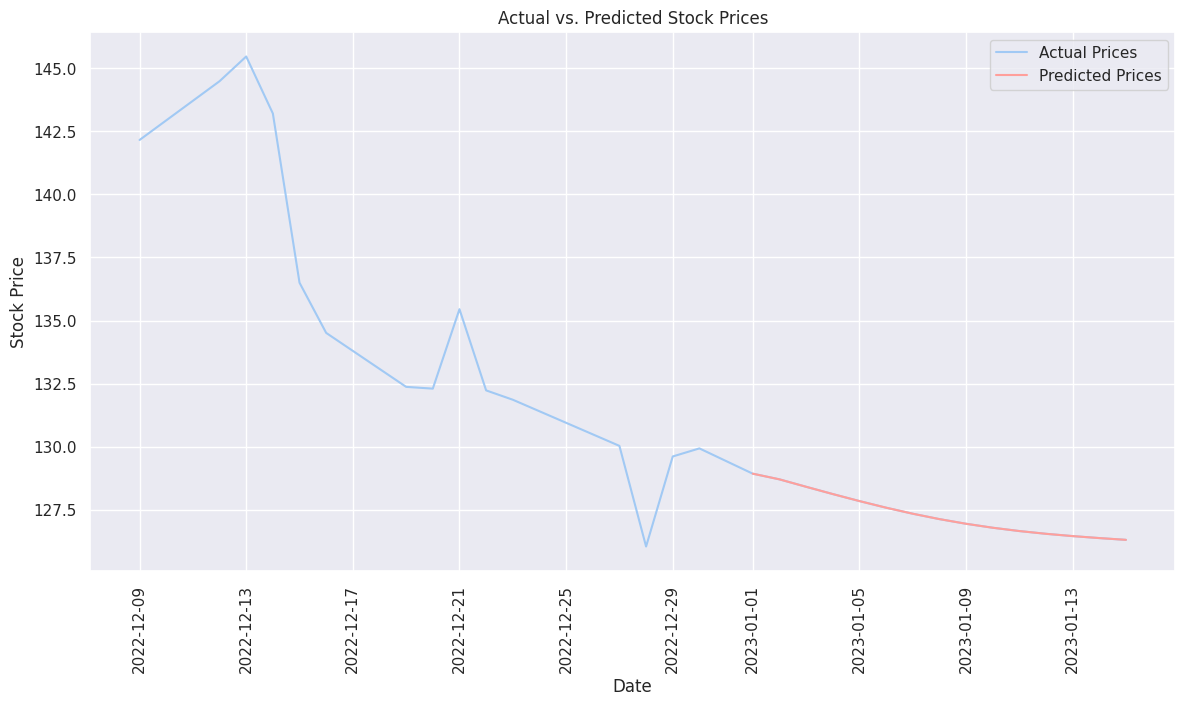

In [ ]:
# Predict the next 15 days of prices
num_predictions = 15  # Change to 15 days for prediction
predicted_prices = predict_future_prices(model, input_data_for_prediction, sequence_length, num_predictions, scaler_test)

# Calculate the dates for predicted prices (next 'num_display_days' days)
predicted_dates = pd.date_range(start=end_date, periods=num_display_days).tolist()

# Combine actual and predicted data for the chart
days = last_actual_dates + predicted_dates
prices_actual = last_actual_prices + predicted_prices

# Create a single line chart to visualize both actual and predicted prices
plt.figure(figsize=(14,7))
plt.plot(days, prices_actual, linestyle='-', color='b', label='Actual Prices')
plt.plot(days[-num_display_days:], predicted_prices, linestyle='-', color='r', label='Predicted Prices')

# Add labels and title
plt.xlabel('Date')
plt.xticks(rotation = 90)
plt.ylabel('Stock Price')
plt.title('Actual vs. Predicted Stock Prices')

# Show a legend
plt.legend()

# Display the chart
plt.show()
